# Algorithm

## ambiente

In [29]:
# librerias
import gym
from gym import Env, spaces
import numpy as np
from stable_baselines3 import PPO

# Utilidad
import json
import copy # Para copiar las variables originales a las que el ambiente edite para cuando se haga un reset
import random

In [30]:
# ENVIRONMENT
class OrganizationEnvironment(gym.Env):
    def __init__(self, preferencias = None, rendering = False):
        super(OrganizationEnvironment, self).__init__()

        self.all_rewards = []
        self.rendering = rendering

        if(preferencias == None):
            self.preferencias = self.get_preferencias()
        else:
            self.preferencias = preferencias

        self.num_estudiantes = len(self.preferencias)
        self.num_desafios = len(self.preferencias[0])

        self.num_preferencias = 0
        for i in self.preferencias:
            for j in i:
                if j > self.num_preferencias:
                    self.num_preferencias = j


        self.state = [[ 0 for _ in range(self.num_desafios)] for _ in range(self.num_estudiantes)]
        self.current_ids = list(range(len(self.preferencias)))
        self.reset()

        # Definición de espacio de observación
        self.observation_space = spaces.MultiDiscrete([2] * (self.num_estudiantes * self.num_desafios) + \
                                                      [self.num_desafios] * (self.num_estudiantes * self.num_desafios))
        # Definición de espacio de acción
        self.action_space = spaces.MultiDiscrete([self.num_estudiantes, self.num_desafios])

    def _set_preferencias(self, preferencias):
        self.preferencias = preferencias

    def get_preferencias(self):
        num_estudiantes = 12
        num_desafios = 9

        preferencias_totales = []

        for i in range(num_estudiantes):
            preferencias_estudiante = [0] * (num_desafios)
            numero_preferencia = 1

            while True:
                desafio = random.randint(0, num_desafios - 1)
                if(preferencias_estudiante[desafio] == 0):
                    preferencias_estudiante[desafio] = numero_preferencia
                    numero_preferencia += 1
                if(numero_preferencia > 5):
                    break
            preferencias_totales.append(preferencias_estudiante)

        if(self.rendering):
            print("\t      Preferencias")
            for index, fila in enumerate(preferencias_totales):
                print(f"Alumno {index}: ",fila)

        return preferencias_totales

    def render(self):
        print("\t\t Desafíos\t\t\t Preferencias")
        for index, fila in enumerate(self.state):
            print(f"Alumno {index}: \t",fila,"\t",self.preferencias[index])

    def reset(self):

        last_observation = self._get_observation()

        self.lives = 3
        self.racha_de_aciertos = 0
        # self.preferencias = self.get_preferencias()
        self.reward_acumulado = 0
        self.num_estudiantes = len(self.preferencias)
        self.num_desafios = len(self.preferencias[0])

        self.num_preferencias = 0
        for i in self.preferencias:
            for j in i:
                if j > self.num_preferencias:
                    self.num_preferencias = j


        # Espacio de observación
        self.state = [[ 0 for _ in range(self.num_desafios)] for _ in range(self.num_estudiantes)]
        self.current_ids = list(range(len(self.preferencias)))

        return last_observation

    def step(self, action):
        assert self.action_space.contains(action), "Invalid Action"

        id_estudiante = action[0]
        id_desafio = action[1]

        done = self.check_done()

        if self._chech_possible(id_estudiante, id_desafio):

            self.state[id_estudiante][id_desafio] = 1

            if(not done):
                contador_escogidos = 0
                for estudiante in self.state:
                    for desafio in estudiante:
                        contador_escogidos += desafio

            reward = self.get_reward([id_estudiante, id_desafio])
        else:
            reward = -10
        # else:
        #     self.lives -= 1
        #     reward = -10 #- (3 - self.lives)

        # if not(self.lives > 0):
        #     done = True
            # reward = -90
        done = self.check_done()
        self.reward_acumulado += reward
        # observation = [self.state, self.preferencias]
        observation = self._get_observation()
        info = {}

        if done:
            self.all_rewards.append(self.reward_acumulado)
            return observation, self.reward_acumulado, done, info
        return observation, reward, done, info


    def _chech_possible(self, id_estudiante, id_desafio):
        # Ver si el estudiante ya esta dentro de un desafío
        total_desafios_asignados = 0
        for desafio_estudiante in self.state[id_estudiante]:
            total_desafios_asignados += desafio_estudiante
        if(total_desafios_asignados > 0):
            return False

        return True

    def _get_observation(self):
        # Aplanar el estado y las preferencias para ajustarse al espacio de observación
        return [self.state[i][j] for i in range(self.num_estudiantes) for j in range(self.num_desafios)] + \
               [self.preferencias[i][j] for i in range(self.num_estudiantes) for j in range(self.num_desafios)]

    def get_reward(self, action):
        id_estudiante = action[0]
        id_desafio = action[1]

        reward = 0
        # Reward por las preferencias
        reward +=   (self.num_preferencias - self.preferencias[id_estudiante][id_desafio] + 1)*2 \
                    if self.preferencias[id_estudiante][id_desafio] != 0 \
                    else -1
        return reward

    def check_done(self):
        # Condición para finalizar el episodio
        contador_de_estudiantes = 0
        for estudiante in self.state:
            for seleccion in estudiante:
                contador_de_estudiantes += seleccion

        if(contador_de_estudiantes == self.num_estudiantes):
            return True

        return False

env = OrganizationEnvironment()
model = PPO.load("ppo_model_v5.zip", env = env)

c:\Users\salb7\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\salb7\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\salb7\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


### 1

In [31]:
# parametros
cantidad_estudiantes = 10
cantidad_desafios = 4
capacidad_desafio = 3

### 2

In [32]:
# preferencias estudiantes aleatorias
def generar_preferencias():
    lista_preferencias = []
    for i in range(cantidad_estudiantes):
        preferencias_estudiante = [0] * (cantidad_desafios)
        preferencia_actual = 1

        while True:
            desafio = random.randint(0, cantidad_desafios - 1)
            if(preferencias_estudiante[desafio] == 0):
                preferencias_estudiante[desafio] = preferencia_actual
                preferencia_actual = preferencia_actual + 1
            if(preferencia_actual > 3):
                break
        lista_preferencias.append(preferencias_estudiante)

    return lista_preferencias

In [33]:
# array con las preferencias de los estudiantes
p = generar_preferencias()
print(p)
preferencias = np.array(p)
print(preferencias)

print("\t\t Eleccion")
for index, lista in enumerate(preferencias):
    print(f"Estudiante {index}: ", lista)

# matriz de asignacion de desafios
asignaciones = np.zeros((cantidad_estudiantes, cantidad_desafios))
#print("\t")
#print(asignaciones)

[[3, 1, 2, 0], [0, 2, 3, 1], [0, 2, 3, 1], [1, 0, 3, 2], [0, 1, 2, 3], [1, 3, 0, 2], [1, 0, 2, 3], [1, 0, 3, 2], [1, 3, 0, 2], [0, 1, 2, 3]]
[[3 1 2 0]
 [0 2 3 1]
 [0 2 3 1]
 [1 0 3 2]
 [0 1 2 3]
 [1 3 0 2]
 [1 0 2 3]
 [1 0 3 2]
 [1 3 0 2]
 [0 1 2 3]]
		 Eleccion
Estudiante 0:  [3 1 2 0]
Estudiante 1:  [0 2 3 1]
Estudiante 2:  [0 2 3 1]
Estudiante 3:  [1 0 3 2]
Estudiante 4:  [0 1 2 3]
Estudiante 5:  [1 3 0 2]
Estudiante 6:  [1 0 2 3]
Estudiante 7:  [1 0 3 2]
Estudiante 8:  [1 3 0 2]
Estudiante 9:  [0 1 2 3]


### 3

In [34]:
"""
Funcion objetivo para asignar estudiantes
maximizar puntaje por asignacion
si la asignacion es de preferencia alta, mas puntaje que si fuese preferencia baja
"""
def FO(preferencias, asignaciones):

    puntaje = 0

    for i in range(cantidad_estudiantes):
        for j in range(cantidad_desafios):
            if (asignaciones[i, j] == 1):
                puntaje = puntaje + (1 / preferencias[i, j])
    return puntaje

In [82]:
"""
funcion de restricciones

agregar: diversidad de los equipos (dura: cada equipo debe estar formado por al menos un par de estudiantes de distintas carreras, blanda: se penaliza si el equipo son todos de una carrera, 
y se premia si se tiene el caso contrario?)

agregar: penalizaciones si se tiene que un estudiante fue agregado a un desafio fuera de sus preferencias, va a pasar eventualmente(blanda)

agregar: si un desafio termina con un solo estudiante seleccionado, penalizar o alertar, ya que ese desafio no se podria aplicar (moverlo a otro desafio) (dura)
"""
def restricciones(asignaciones, capacidad_desafio):
    # r1: cada desafio no tiene mas de n estudiantes
    for desafio in range(cantidad_desafios):
        #print("hola")
        if (np.sum(asignaciones[:, desafio]) >= capacidad_desafio):
            print("Equipo muy grande!")
            return False
        
    # r2: cada estudiante solo puede ser asignado a un desafio
    for estudiante in range(cantidad_estudiantes):
        #print(np.sum(asignaciones[estudiante, :]))
        if (np.sum(asignaciones[estudiante, :]) != 1):
            print("Estudiante asignado en mas de un desafio!")
            return False
    
    print("La distribucion cumple con las restricciones!")
    return True

In [83]:
"""
funcion de asignacion de estudiantes
"""

def dividir(lista):
    return [lista[i:i + 9] for i in range(0, len(lista), 9)]

def distribucion_estudiantes(obs):
    # matriz de asignacion de desafios
    asign = obs[: 108]
    asignaciones = np.array(dividir(asign))
    #print(asignaciones)

    pref = obs[108 :]
    preferencias = np.array(dividir(pref))
    #print(pref)
    #print(obs)
    #return env.action_space.sample()
    for estudiante in range(env.num_estudiantes):
        if (np.sum(asignaciones[estudiante, :]) > 0):
            continue
        for preferencia in range(1, env.num_desafios + 1):
            desafio_preferido = np.where(preferencias[estudiante] == preferencia)[0][0]
            if (np.sum(asignaciones[:, desafio_preferido]) < capacidad_desafio):
                return [estudiante, desafio_preferido]
                #asignaciones[estudiante, desafio_preferido] = 1
                break
    #return asignaciones

env.reset()
obs = env._get_observation()

a = np.array(dividir(obs[: 108]))
b = np.array(dividir(obs[108 :]))

# print(a)
# print("\t")
# print(b)
# print("\t")

while True:
    action = distribucion_estudiantes(obs)
    env.render()
    print("\t")
    print("Acción:", action)
    obs, reward, done, info = env.step(action)
    #print("\n\n")
    env.render()
    print("\t")
    print(f"reward:",reward)
    print("\n\n")
    if done == True:
        break

#print(env.state)
tamaño_equipos = [sum(elemento) for elemento in zip(*env.state)]
print(f"Cantidad de alumnos en cada desafío:", tamaño_equipos)
print("\t")
for index in range(len(tamaño_equipos)):
    print(f"En el desafío {index} hay {tamaño_equipos[index]} estudiantes asignados.")
total_estudiantes = sum(tamaño_equipos)
print(f"el total de estudiantes asignados es:", total_estudiantes)
state_check = np.array(env.state)
#print(state_check)
#print(obs)
new_obs = np.array(dividir(obs[: 108]))
print(new_obs)
print("\t")
restricciones(state_check, 3)
print("\t")
for estudiante in range(len(new_obs)):
    for desafio in range(len(new_obs[estudiante])):
        if new_obs[estudiante][desafio] == 1:
            print(f"Estudiante {estudiante} asignado a desafío {desafio}")

		 Desafíos			 Preferencias
Alumno 0: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [4, 5, 0, 0, 2, 0, 1, 3, 0]
Alumno 1: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 0, 2, 0, 4, 0, 1, 3, 5]
Alumno 2: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [1, 3, 2, 0, 5, 0, 0, 4, 0]
Alumno 3: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [2, 5, 3, 0, 0, 0, 4, 0, 1]
Alumno 4: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [4, 0, 0, 0, 5, 3, 2, 0, 1]
Alumno 5: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 0, 5, 4, 2, 0, 1, 0, 3]
Alumno 6: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [3, 2, 0, 0, 0, 4, 0, 5, 1]
Alumno 7: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [5, 0, 0, 0, 2, 3, 0, 4, 1]
Alumno 8: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 0, 3, 0, 2, 1, 4, 5, 0]
Alumno 9: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [3, 0, 5, 2, 0, 0, 1, 4, 0]
Alumno 10: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 3, 5, 0, 1, 4, 0, 2, 0]
Alumno 11: 	 [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [0, 0, 3, 0, 4, 2, 1, 0, 5]
	
Acción: [0, 6]
		 Desafíos			 Preferencias
Alumno 0: 	 [0, 0, 0, 0, 0, 0, 1, 0, 0] 	 [4, 5, 0, 0, 2, 0, 1, 3, 0]
Alumno 1: 	 [0,

In [79]:
def satisfaccion(obs):

    satisfaccion = 0

    obs_1 = np.array(dividir(obs[: 108]))
    obs_2 = np.array(dividir(obs[108 :]))

    for estudiante in range(len(obs_1)):
        desafio_asignado = np.argmax(obs_1[estudiante])
        print(desafio_asignado)

        preferencia_seleccionada = obs_2[estudiante, desafio_asignado]
        print(preferencia_seleccionada)
        print("\t")
        if preferencia_seleccionada > 0:
            satisfaccion = satisfaccion + (1 / preferencia_seleccionada)

    porcentaje = (satisfaccion / len(obs_1)) * 100
    return porcentaje


In [81]:
print(f"El porcentaje de satisfacción para la distribución es: {satisfaccion(obs)}")

6
1
	
6
1
	
0
1
	
8
1
	
8
1
	
6
1
	
8
1
	
4
2
	
5
1
	
3
2
	
4
1
	
5
2
	
El porcentaje de satisfacción para la distribución es: 87.5


In [37]:
# VERSUS

env_modelo = OrganizationEnvironment()
env_algoritmo = OrganizationEnvironment()


EPISODES = 70
rewards_modelo = []
rewards_algoritmo = []
for i in range(EPISODES):
    env_modelo.reset()
    env_algoritmo.reset()
    env_algoritmo._set_preferencias(env_modelo.preferencias)

    obs_modelo = env_modelo._get_observation()
    obs_algoritmo = env_algoritmo._get_observation()
    while True:
        action_modelo, _states = model.predict(obs_modelo)
        print("action_modelo: ", action_modelo)
        obs_modelo, reward_modelo, done_modelo, info = env_modelo.step(action_modelo)
        if done_modelo == True:
            break
    print("\n MODELO:", reward_modelo)
    env_modelo.render()
    rewards_modelo.append(reward_modelo)
    while True:
        action_algoritmo = distribucion_estudiantes(obs_algoritmo)
        print("action_algoritmo: ", action_algoritmo)
        obs_algoritmo, reward_algoritmo, done_algoritmo, info = env_algoritmo.step(action_algoritmo)
        if done_algoritmo == True:
            break
    print("\n ALGORITMO:", reward_algoritmo)
    env_algoritmo.render()
    rewards_algoritmo.append(reward_algoritmo)

action_modelo:  [3 5]
action_modelo:  [11  5]
action_modelo:  [0 5]


action_modelo:  [5 5]
action_modelo:  [10  5]
action_modelo:  [9 5]
action_modelo:  [7 3]
action_modelo:  [2 3]
action_modelo:  [4 5]
action_modelo:  [6 7]
action_modelo:  [8 7]
action_modelo:  [1 7]

 MODELO: 58
		 Desafíos			 Preferencias
Alumno 0: 	 [0, 0, 0, 0, 0, 1, 0, 0, 0] 	 [0, 2, 0, 1, 0, 3, 5, 4, 0]
Alumno 1: 	 [0, 0, 0, 0, 0, 0, 0, 1, 0] 	 [0, 0, 0, 3, 0, 5, 4, 2, 1]
Alumno 2: 	 [0, 0, 0, 1, 0, 0, 0, 0, 0] 	 [0, 4, 5, 1, 2, 3, 0, 0, 0]
Alumno 3: 	 [0, 0, 0, 0, 0, 1, 0, 0, 0] 	 [0, 3, 4, 5, 0, 2, 0, 0, 1]
Alumno 4: 	 [0, 0, 0, 0, 0, 1, 0, 0, 0] 	 [0, 3, 2, 4, 1, 0, 0, 5, 0]
Alumno 5: 	 [0, 0, 0, 0, 0, 1, 0, 0, 0] 	 [0, 3, 2, 4, 1, 0, 5, 0, 0]
Alumno 6: 	 [0, 0, 0, 0, 0, 0, 0, 1, 0] 	 [3, 0, 5, 1, 2, 0, 0, 4, 0]
Alumno 7: 	 [0, 0, 0, 1, 0, 0, 0, 0, 0] 	 [4, 0, 0, 1, 2, 0, 3, 0, 5]
Alumno 8: 	 [0, 0, 0, 0, 0, 0, 0, 1, 0] 	 [0, 4, 3, 0, 5, 0, 2, 1, 0]
Alumno 9: 	 [0, 0, 0, 0, 0, 1, 0, 0, 0] 	 [5, 1, 0, 2, 4, 0, 3, 0, 0]
Alumno 10: 	 [0, 0, 0, 0, 0, 1, 0, 0, 0] 	 [3, 5, 0, 4, 2, 

[]

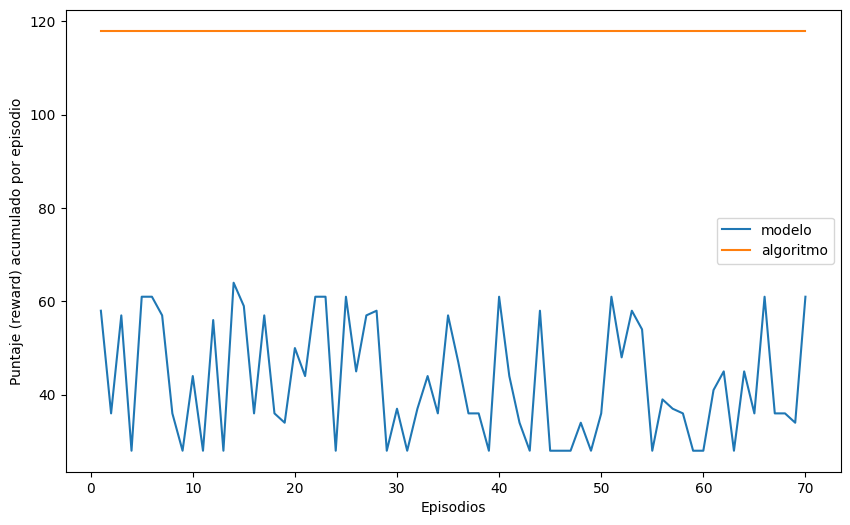

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

x = list(range(1, 71))
y1 = rewards_modelo
y2 = rewards_algoritmo

plt.plot(x, y1, label = 'modelo')
plt.plot(x, y2, label = 'algoritmo')

plt.xlabel("Episodios")
plt.ylabel("Puntaje (reward) acumulado por episodio")

plt.legend()
plt.plot()